In [1]:
import numpy as np
import pandas as pd

np.random.seed(314159) # set random seed

import torch
import pytorch_lightning as pl

from torch_geometric.data import Data

import wandb

In [2]:
import os
os.chdir('F:/gene prioritization/genedragnn/')
cwd = os.getcwd()
cwd

'F:\\gene prioritization\\genedragnn'

In [3]:
# load edge list
edge_list_path = 'ESCA/esca_other_way/edge_list.npy'
edge_list = torch.Tensor(np.load(edge_list_path).T).type(torch.int64) # read in format expected by pytorch geometric [2, n_edges]

# load protein-ID dictionary (need new ID system starting at index 0 for pytorch geometric)
protein_id_dict = np.load('ESCA/esca_other_way/protein_ids_dict.npy', allow_pickle=True).item() # maps my custom ID system to Ensembl IDs
protein_id_dict_inv = {ensembl: id_ for id_, ensembl in protein_id_dict.items()} 


In [4]:
data_path = 'ESCA/esca_other_way/node_dataset.csv' #NOTE: labels are generated from infomation in this dataset
node_dataset = pd.read_csv(data_path, index_col=1)
node_dataset
# map dataset
# map dataset
myID = node_dataset.index.map(protein_id_dict_inv).rename('myID')
node_dataset.insert(loc=0, column='myID', value=myID)
node_dataset = node_dataset.reset_index().set_index('myID')



In [5]:
# ensure that the index is in the correct order
node_dataset.sort_index(inplace=True)

# reset the index to the default integer index
node_dataset.reset_index(drop=True, inplace=True)

In [6]:
assert((node_dataset.index.to_numpy() == np.arange(len(node_dataset))).all())

In [7]:
# create positives
label_name = 'my_label'

# find positives
pos_label_col = 'gda_score' #FIXME: figure out meaning of columns and determing appropriate choice of positive labels
node_dataset[pos_label_col].fillna(0, inplace=True) # Replace NaN values with 0  # Replace NaN values with 0
pos_labels = pd.array([1 if row[pos_label_col] else None for id_, row in node_dataset.iterrows()], dtype='Int32')
node_dataset[label_name] = pos_labels

# create negatives
def sample_negatives(PU_labels):
    '''randomly samples from the unlabeled samples'''

    # sample same # as positives
    num_pos = (PU_labels==1).sum()
    neg_inds = PU_labels[PU_labels.isna()].sample(num_pos).index

    # TODO: more sophisticated methods for sampling methods. (e.g.: use mutation rate, unsupervised learning, etc.)

    return neg_inds # returns ID's of negative samples

neg_label_inds = sample_negatives(node_dataset[label_name])
node_dataset.loc[neg_label_inds, label_name] = 0

# TODO: save this data for reproducibility (not now, but once this is finalized and fixed)

node_dataset[label_name].value_counts()

my_label
1    96
0    96
Name: count, dtype: Int64

In [8]:
label_col = label_name
node_dataset[label_col] = node_dataset[label_col].astype('Int32')

# TODO: decide whether or not to include network embedding features...
num_node_feats = 100
node_feat_cols = [f'hpa_{i}' for i in range(num_node_feats)]

# get subset of node features features + labels
node_data = node_dataset[node_feat_cols + [label_col]]

X = torch.Tensor(node_data[node_feat_cols].to_numpy())#.type(torch.float64)

y = node_data[label_col].fillna(-1).astype('int') # fill NaN with -1 so that it can be converted to pytorch tensor
y = torch.Tensor(y).type(torch.int64)

# restrict to data with labels
node_data_labeled = node_data[node_data[label_col].notna()]
node_data_labeled

,hpa_0,hpa_1,hpa_2,hpa_3,hpa_4,hpa_5,hpa_6,hpa_7,hpa_8,hpa_9,...,hpa_91,hpa_92,hpa_93,hpa_94,hpa_95,hpa_96,hpa_97,hpa_98,hpa_99,my_label
1,2.622885,0.091777,1.556862,-1.150336,0.604880,0.576295,0.111428,-0.357417,-0.089766,0.544997,...,0.487026,-0.212421,0.155076,0.051306,-0.015217,0.012334,0.042052,0.116839,0.145195,1
3,1.302459,0.359458,0.487266,-0.170039,-0.612161,0.668402,-0.178675,-0.020758,-1.233427,-0.138608,...,0.156555,0.535861,-0.001705,-0.207785,-0.030965,0.244557,0.206571,-0.007231,0.047298,0
4,1.480702,0.846315,0.805986,0.485906,-0.200129,0.917416,1.442815,-0.491646,-0.742964,-0.351460,...,0.043994,0.009029,0.025394,-0.019587,-0.045341,-0.057739,-0.032169,-0.070050,-0.005607,0
6,2.827703,-0.172341,1.647666,-1.270841,0.872553,0.578307,0.075595,-0.315364,-0.112559,0.609097,...,-0.300689,0.079337,-0.257716,0.083479,0.040671,0.152466,0.223977,-0.155832,0.222694,1
10,1.243029,1.266329,0.965510,0.452555,-0.409319,1.230919,0.996257,0.164401,-0.871694,-0.552078,...,-0.063135,0.184002,-0.026195,-0.072382,-0.041434,0.171305,0.080698,0.097408,0.041385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,1.164393,0.630591,0.180641,0.582467,-0.106467,-0.209547,-0.081625,0.248931,-0.390761,-0.579473,...,0.001713,0.059122,0.017188,-0.106874,-0.050534,-0.109417,0.018077,0.010970,0.045092,0
634,3.208254,0.429645,1.469789,-0.193957,0.493516,0.964159,0.621979,-0.004250,0.537261,0.218720,...,-0.149295,0.386315,0.403754,-0.018071,0.211136,-0.182006,-0.039422,0.201049,-0.362338,0
636,1.427316,-0.840732,0.394395,0.038952,0.034034,0.623135,-0.129531,-0.521732,-0.836840,0.245802,...,-0.010235,-0.004336,0.010788,0.009675,-0.002396,0.016513,-0.006846,0.002559,-0.029099,0
639,2.268771,-0.845675,1.635329,0.944473,0.354162,0.392343,-0.006447,0.014524,-0.524891,0.571226,...,-0.016917,0.052344,-0.022775,0.041667,0.000634,0.004810,-0.058851,-0.040033,-0.013418,1


In [9]:
from sklearn.model_selection import train_test_split

X_myIDs = node_data_labeled.index.to_numpy() # myIDs for nodes with labels for training/testing
labels = node_data_labeled[label_col].to_numpy() # for stratification

test_size = 0.2
val_size = 0.1 * (1/(1-test_size))

myIDs_train_val, myIDs_test = train_test_split(X_myIDs, test_size=test_size, shuffle=True, stratify=labels)

labels_train_val = node_data_labeled.loc[myIDs_train_val][label_col].to_numpy()
myIDs_train, myIDs_val = train_test_split(myIDs_train_val, test_size=val_size, shuffle=True, stratify=labels_train_val)

# NOTE: train-val-test split is shuffled and stratified
# TODO: look into any special consideration necessary for train-test splits on graph-based models

# create masks
n_nodes = len(node_data)
train_mask = np.zeros(n_nodes, dtype=bool)
train_mask[myIDs_train] = True
train_mask = torch.Tensor(train_mask).type(torch.bool)

val_mask = np.zeros(n_nodes, dtype=bool)
val_mask[myIDs_val] = True
val_mask = torch.Tensor(val_mask).type(torch.bool)

test_mask = np.zeros(n_nodes, dtype=bool)
test_mask[myIDs_test] = True
test_mask = torch.Tensor(test_mask).type(torch.bool)

In [10]:
data = Data(x=X, y=y, edge_index=edge_list)
num_classes = 2
num_features = X.shape[1]
print(num_features)


data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

100


In [11]:
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

# define GNN architecture
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, hidden_dense, GNN_conv_layer=GCNConv, dropout_rate=0.1, **kwargs):
        """
        Args:
            num_features (int): Dimension of input features
            hidden_channels (List[int]): Dimension of hidden features
            num_classes (int): Dimension of the output.
            hidden_dense (int): number of units in hidden dense layer following convolutions.
            GNN_conv_layer: Class of the graph convolutional layer to use.
            dropout_rate (float): Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()

        self.convs = []
        self.convs.append(GNN_conv_layer(in_channels=num_features, out_channels=hidden_channels[0], **kwargs)) # first GNN Conv layer

        for c1, c2 in zip(hidden_channels[:-1], hidden_channels[1:]): # middle layers
            self.convs.append(GNN_conv_layer(in_channels=c1, out_channels=c2, **kwargs))

        self.convs = torch.nn.ModuleList(self.convs)

        self.dense1 = torch.nn.Linear(hidden_channels[-1], hidden_dense)
        self.dense_out = torch.nn.Linear(hidden_dense, num_classes)

        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        """
        Args:
            x: node features
            edge_index: edge list
        """

        for i,conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.dense1(x)
        x = x.relu()
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.dense_out(x)

        return x
import pytorch_lightning as pl

# define Pytorch Lightning model
class LitGNN(pl.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.validation_step_outputs = []

        self.model_name = model_name
        self.model = GNNModel(**model_kwargs)
        self.loss_module = torch.nn.CrossEntropyLoss()

        self.example_input_array = data

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss and acc on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            raise ValueError(f"Unknown forward mode: {mode}")

        #TODO: add other metrics like recall, precision, f1, etc...
        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()

        return x, loss, acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())#SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits, _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.validation_step_outputs.append(logits)
        return logits

    def on_validation_epoch_end(self):
        # NOTE: can't save non-standard GNN model like this
        # TODO: look into how to save torch geometric models
        # dummy_input = data
        # model_filename = f'{self.model_name}_{str(self.global_step).zfill(5)}.onnx'
        # torch.onnx.export(self, dummy_input, model_filename)
        # wandb.save(model_filename)


        epoch_average = torch.cat(self.validation_step_outputs).mean()
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()  # free memory

    def test_step(self, batch, batch_idx):
        x, _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    # def test_epoch_end(self, test_step_outputs):
    #     # save model as onnx format
    #     pass

In [12]:
import wandb
import os

os.environ["WANDB_API_KEY"] = "f5cdfac0b8652e63e39413c7596cefd6c6858636"
os.environ["WANDB_MODE"] = "online"

config = {
    "dataset": "CIFAR10",
    "machine": "online cluster",
    "model": "CNN",
    "learning_rate": 0.01,
    "batch_size": 128,
}

wandb.init(project="offline-demo")

for i in range(100):
    wandb.log({"accuracy": i})

wandb: Currently logged in as: 22ltph08. Use `wandb login --relogin` to force relogin


In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import torch_geometric.loader

import datetime

model_name = f'gat_{str(datetime.datetime.today())[:10]}'

logger = WandbLogger(name=model_name, project="Project X", log_model="all")


AVAIL_GPUS = min(1, torch.cuda.device_count())

model = LitGNN(model_name, num_features=num_features, hidden_channels=[128, 128],
               num_classes=num_classes, hidden_dense=64, GNN_conv_layer=GCNConv, dropout_rate=0.1)

data_loader = torch_geometric.loader.DataLoader([data], batch_size=1, num_workers=3)
MAX_EPOCHS=250
trainer = pl.Trainer(
    callbacks=[ModelCheckpoint(save_weights_only=False, mode="max", monitor="val_acc"),
               EarlyStopping(monitor="val_acc_epoch", patience=200, verbose=False, mode="max")],
    accelerator='cpu',
    max_epochs=MAX_EPOCHS,
    logger=logger,
)

trainer.fit(model, data_loader, data_loader)
model = LitGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Vaibhav\miniconda3\Lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name        | Type             | Params | In sizes                 | Out sizes
----------------------------------------------------------------------------------------
0 | model       | GNNModel         | 37.8 K | [[644, 100], [2, 51583]] | [644, 2] 
1 | loss_module | CrossEntropyLoss | 0      | [[133, 2], [133]]        | ?        
----------------------------------------------------------------------------------------
37.8 K    Trainable params
0         Non-trainable params
37.8 K    Total params
0.151     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Vaibhav\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\Vaibhav\miniconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 644. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Vaibhav\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\Vaibhav\miniconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=250` reached.


In [59]:
def save_reports(filename, train_reports, test_reports):
    '''saves train and test reports to a json file'''
    if not os.path.exists('project_reports'):
       os.makedirs('project_reports')
    save_dict = {'train_reports': train_reports, "test_reports": test_reports}
    json_string = json.dumps(save_dict)
    json_file = open(f'{filename}.json', 'w')
    json_file.write(json_string)
    json_file.close()

In [60]:
# evaluate model

from sklearn.metrics import classification_report
logits, _, _ = model.forward(data.to(device='cpu'))

preds_train = logits[data.train_mask].argmax(dim=-1)
preds_test = logits[data.test_mask].argmax(dim=-1)

y_train = data.y[data.train_mask]
y_test = data.y[data.test_mask]

train_report = classification_report(y_train, preds_train, labels=[0,1], target_names=['negative', 'positive'])
test_report = classification_report(y_test, preds_test, labels=[0,1], target_names=['negative', 'positive'])

print('training metrics')
print(train_report)
print('testing metrics')
print(test_report)

training metrics
              precision    recall  f1-score   support

    negative       0.80      0.83      0.81        66
    positive       0.83      0.79      0.81        67

    accuracy                           0.81       133
   macro avg       0.81      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133

testing metrics
              precision    recall  f1-score   support

    negative       0.78      0.70      0.74        20
    positive       0.71      0.79      0.75        19

    accuracy                           0.74        39
   macro avg       0.75      0.74      0.74        39
weighted avg       0.75      0.74      0.74        39



In [14]:
# evaluate model

from sklearn.metrics import classification_report
logits, _, _ = model.forward(data.to(device='cpu'))

preds_train = logits[data.train_mask].argmax(dim=-1)
preds_test = logits[data.test_mask].argmax(dim=-1)

y_train = data.y[data.train_mask]
y_test = data.y[data.test_mask]

train_report = classification_report(y_train, preds_train, labels=[0,1], target_names=['negative', 'positive'])
test_report = classification_report(y_test, preds_test, labels=[0,1], target_names=['negative', 'positive'])

print('training metrics')
print(train_report)
print('testing metrics')
print(test_report)

training metrics
              precision    recall  f1-score   support

    negative       0.85      0.95      0.90        66
    positive       0.95      0.84      0.89        67

    accuracy                           0.89       133
   macro avg       0.90      0.90      0.89       133
weighted avg       0.90      0.89      0.89       133

testing metrics
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68        20
    positive       0.67      0.74      0.70        19

    accuracy                           0.69        39
   macro avg       0.69      0.69      0.69        39
weighted avg       0.70      0.69      0.69        39



In [14]:
# evaluate model

from sklearn.metrics import classification_report
logits, _, _ = model.forward(data.to(device='cpu'))

preds_train = logits[data.train_mask].argmax(dim=-1)
preds_test = logits[data.test_mask].argmax(dim=-1)

y_train = data.y[data.train_mask]
y_test = data.y[data.test_mask]

train_report = classification_report(y_train, preds_train, labels=[0,1], target_names=['negative', 'positive'])
test_report = classification_report(y_test, preds_test, labels=[0,1], target_names=['negative', 'positive'])

print('training metrics')
print(train_report)
print('testing metrics')
print(test_report)

training metrics
              precision    recall  f1-score   support

    negative       0.70      0.86      0.78        66
    positive       0.83      0.64      0.72        67

    accuracy                           0.75       133
   macro avg       0.77      0.75      0.75       133
weighted avg       0.77      0.75      0.75       133

testing metrics
              precision    recall  f1-score   support

    negative       0.68      0.75      0.71        20
    positive       0.71      0.63      0.67        19

    accuracy                           0.69        39
   macro avg       0.69      0.69      0.69        39
weighted avg       0.69      0.69      0.69        39



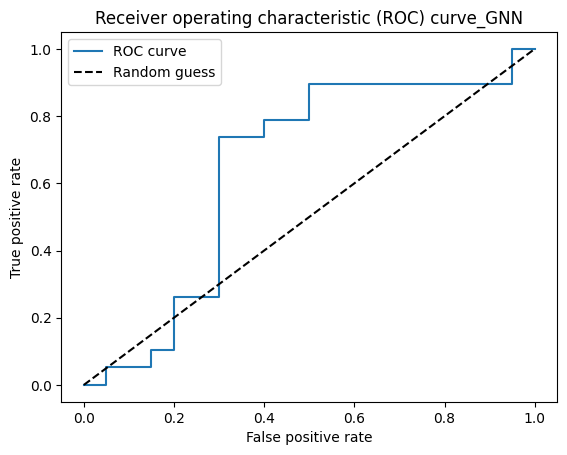

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute true positive rate and false positive rate for all thresholds
fpr, tpr, thresholds = roc_curve(data.y[data.test_mask], logits[data.test_mask][:, 1].detach().numpy())

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic (ROC) curve_GNN')
plt.legend()

# Display plot
plt.show()

# Save plot as TIFF file
plt.savefig('roc_curve.tiff', dpi=1200, format='tif')

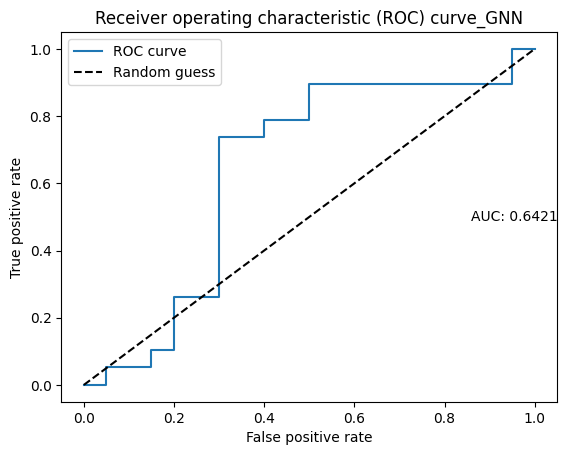

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch
import torch_geometric
from torch_geometric.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Compute true positive rate and false positive rate for all thresholds
fpr, tpr, thresholds = roc_curve(data.y[data.test_mask], logits[data.test_mask][:, 1].detach().numpy())

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic (ROC) curve_GNN')
plt.legend()

# Compute AUC
auc = roc_auc_score(data.y[data.test_mask], logits[data.test_mask][:, 1].detach().numpy())

# Add AUC value to plot
plt.text(1.0, 0.5, f'AUC: {auc:.4f}', transform=plt.gca().transAxes, ha='right', va='center')

# Display plot
plt.show()

# Save plot as TIFF file
plt.savefig('roc_curve.tiff', dpi=1200, format='tif')

NameError: name 'data' is not defined

In [21]:
# Get gene IDs and GNN scores
gene_ids = node_data.index.to_numpy()
gnn_scores_negative = logits[:, 0].detach().numpy()
gnn_scores_positive = logits[:, 1].detach().numpy()

# Zip gene IDs and GNN scores together
gene_gnn_scores_negative = list(zip(gene_ids, gnn_scores_negative))
gene_gnn_scores_positive = list(zip(gene_ids, gnn_scores_positive))

# Sort genes by GNN score in descending order
sorted_gene_gnn_scores_negative = sorted(gene_gnn_scores_negative, key=lambda x: x[1], reverse=True)
sorted_gene_gnn_scores_positive = sorted(gene_gnn_scores_positive, key=lambda x: x[1], reverse=True)

# Perform Wilcoxon signed-rank test for the positive label
from scipy.stats import wilcoxon
w, p = wilcoxon(gnn_scores_negative, gnn_scores_positive)

# Print top 10 genes by GNN score for the negative label
print("Top 10 genes by negative GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f}")

# Print top 10 genes by GNN score for the positive label
print("Top 10 genes by positive GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})")

# Save the output to a file
with open("output.txt", "w") as f:
    f.write("Top 10 genes by negative GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f}\n")

    f.write("\nTop 10 genes by positive GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})\n")

Top 10 genes by negative GNN score:
1. 49: 10.0988
2. 72: 9.9555
3. 111: 6.5412
4. 235: 5.7048
5. 274: 5.6362
6. 255: 5.2603
7. 349: 5.1855
8. 509: 5.0810
9. 173: 5.0595
10. 406: 4.9853
Top 10 genes by positive GNN score:
1. 51: 12.4607 (p-value: 0.0000)
2. 167: 8.1248 (p-value: 0.0000)
3. 159: 7.7503 (p-value: 0.0000)
4. 128: 5.3213 (p-value: 0.0000)
5. 67: 5.2453 (p-value: 0.0000)
6. 286: 4.8806 (p-value: 0.0000)
7. 497: 4.8659 (p-value: 0.0000)
8. 239: 4.7349 (p-value: 0.0000)
9. 295: 4.4513 (p-value: 0.0000)
10. 303: 4.0913 (p-value: 0.0000)


In [19]:
# Get gene IDs and GNN scores
gene_ids = node_data.index.to_numpy()
gnn_scores_negative = logits[:, 0].detach().numpy()
gnn_scores_positive = logits[:, 1].detach().numpy()

# Zip gene IDs and GNN scores together
gene_gnn_scores_negative = list(zip(gene_ids, gnn_scores_negative))
gene_gnn_scores_positive = list(zip(gene_ids, gnn_scores_positive))

# Sort genes by GNN score in descending order
sorted_gene_gnn_scores_negative = sorted(gene_gnn_scores_negative, key=lambda x: x[1], reverse=True)
sorted_gene_gnn_scores_positive = sorted(gene_gnn_scores_positive, key=lambda x: x[1], reverse=False)

# Perform Wilcoxon signed-rank test for the positive label
from scipy.stats import wilcoxon
w, p = wilcoxon(gnn_scores_negative, gnn_scores_positive)

# Print top 10 genes by GNN score for the negative label
print("Top 10 genes by negative GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f}")

# Print top 10 genes by GNN score for the positive label
print("Top 10 genes by positive GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})")

# Save the output to a file
with open("Negative GNN", "w") as f:
    f.write("Top 10 genes by negative GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:]):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f}\n")

    f.write("\nTop 10 genes by positive GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})\n")

Top 10 genes by negative GNN score:
1. 72: 6.0989
2. 49: 4.9008
3. 111: 3.4372
4. 173: 3.2858
5. 274: 3.2320
6. 235: 3.2217
7. 260: 3.1899
8. 255: 3.1471
9. 73: 2.9283
10. 349: 2.8657
Top 10 genes by positive GNN score:
1. 72: -4.8755 (p-value: 0.0000)
2. 49: -3.9128 (p-value: 0.0000)
3. 111: -3.3259 (p-value: 0.0000)
4. 173: -2.6814 (p-value: 0.0000)
5. 260: -2.6661 (p-value: 0.0000)
6. 255: -2.5064 (p-value: 0.0000)
7. 573: -2.4306 (p-value: 0.0000)
8. 280: -2.3997 (p-value: 0.0000)
9. 73: -2.3848 (p-value: 0.0000)
10. 274: -2.3696 (p-value: 0.0000)


In [28]:

probabilities = F.sigmoid(logits)
gene_ids = node_data.index.to_numpy()
# Extract probabilities for class 0 and class 1
probabilities_class_0 = probabilities[:, 0]
probabilities_class_1 = probabilities[:, 1]
gnn_neg=list(zip(gene_ids,probabilities_class_0 ))
gnn_pos=list(zip(gene_ids,probabilities_class_1 ))


In [30]:
gene_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
probabilities_class0 = probabilities_class_0.tolist()
probabilities_class1 = probabilities_class_1.tolist()
gnn_neg=list(zip(gene_ids,probabilities_class0 ))
gnn_pos=list(zip(gene_ids,probabilities_class1 ))

In [25]:
np_array = gnn_pos
np.savetxt("positive_gnn_try_with_low_AUC.csv", np_array, fmt="%f", delimiter=",")


In [30]:
from scipy.stats import wilcoxon
import numpy as np

# Calculate the p-values for each gene
p_values = np.zeros(len(gene_ids))
for i in range(len(gene_ids)):
    p_values[i] = wilcoxon(gnn_scores_negative[i], gnn_scores_positive[i], alternative='two-sided')[1]

# Adjust the p-values for multiple comparisons using the Holm-Bonferroni method
q_values = np.minimum(1, np.multiply(p_values, np.arange(1, len(gene_ids) + 1)))

# Print the top 10 genes by GNN score for the positive label
print("Top 10 genes by positive GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.24f} (q-value: {q_values[i]:.24f})")

Top 10 genes by positive GNN score:
1. 72: -4.875519275665283203125000 (q-value: 1.000000000000000000000000)
2. 49: -3.912787675857543945312500 (q-value: 1.000000000000000000000000)
3. 111: -3.325895786285400390625000 (q-value: 1.000000000000000000000000)
4. 173: -2.681359052658081054687500 (q-value: 1.000000000000000000000000)
5. 260: -2.666142463684082031250000 (q-value: 1.000000000000000000000000)
6. 255: -2.506444931030273437500000 (q-value: 1.000000000000000000000000)
7. 573: -2.430597543716430664062500 (q-value: 1.000000000000000000000000)
8. 280: -2.399684429168701171875000 (q-value: 1.000000000000000000000000)
9. 73: -2.384836673736572265625000 (q-value: 1.000000000000000000000000)
10. 274: -2.369575977325439453125000 (q-value: 1.000000000000000000000000)


In [26]:
import numpy as np

# Get gene IDs and GNN scores
gene_ids = node_data.index.to_numpy()
gnn_scores_negative = logits[:, 0].detach().numpy()
gnn_scores_positive = logits[:, 1].detach().numpy()

# Set the precision of floating-point numbers when printing
np.set_printoptions(precision=4)

# Zip gene IDs and GNN scores together
gene_gnn_scores_negative = list(zip(gene_ids, gnn_scores_negative))
gene_gnn_scores_positive = list(zip(gene_ids, gnn_scores_positive))

# Sort genes by GNN score in descending order
sorted_gene_gnn_scores_negative = sorted(gene_gnn_scores_negative, key=lambda x: x[1], reverse=True)
sorted_gene_gnn_scores_positive = sorted(gene_gnn_scores_positive, key=lambda x: x[1], reverse=True)

# Perform Wilcoxon signed-rank test for the positive label
from scipy.stats import wilcoxon
w, p = wilcoxon(gnn_scores_negative, gnn_scores_positive)

# Print top 10 genes by GNN score for the negative label
print("Top 10 genes by negative GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f}")

# Print top 10 genes by GNN score for the positive label
print("Top 10 genes by positive GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})")

# Save the output to a file
with open("output.txt", "w") as f:
    f.write("Top 10 genes by negative GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f}\n")

    f.write("\nTop 10 genes by positive GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})\n")

Top 10 genes by negative GNN score:
1. 49: 10.0988
2. 72: 9.9555
3. 111: 6.5412
4. 235: 5.7048
5. 274: 5.6362
6. 255: 5.2603
7. 349: 5.1855
8. 509: 5.0810
9. 173: 5.0595
10. 406: 4.9853
Top 10 genes by positive GNN score:
1. 51: 12.4607 (p-value: 0.0000)
2. 167: 8.1248 (p-value: 0.0000)
3. 159: 7.7503 (p-value: 0.0000)
4. 128: 5.3213 (p-value: 0.0000)
5. 67: 5.2453 (p-value: 0.0000)
6. 286: 4.8806 (p-value: 0.0000)
7. 497: 4.8659 (p-value: 0.0000)
8. 239: 4.7349 (p-value: 0.0000)
9. 295: 4.4513 (p-value: 0.0000)
10. 303: 4.0913 (p-value: 0.0000)


In [31]:
import numpy as np

# Get gene IDs and GNN scores
gene_ids = node_data.index.to_numpy()
gnn_scores_negative = logits[:, 0].detach().numpy()
gnn_scores_positive = logits[:, 1].detach().numpy()

# Set the precision of floating-point numbers when printing
np.set_printoptions(precision=4)

# Zip gene IDs and GNN scores together
gene_gnn_scores_negative = list(zip(gene_ids, gnn_scores_negative))
gene_gnn_scores_positive = list(zip(gene_ids, gnn_scores_positive))

# Sort genes by GNN score in descending order
sorted_gene_gnn_scores_negative = sorted(gene_gnn_scores_negative, key=lambda x: x[1], reverse=True)
sorted_gene_gnn_scores_positive = sorted(gene_gnn_scores_positive, key=lambda x: x[1], reverse=True)

# Perform Wilcoxon signed-rank test for the positive label
from scipy.stats import wilcoxon
w, p = wilcoxon(gnn_scores_negative, gnn_scores_positive)

# Print top 10 genes by GNN score for the negative label
print("Top 10 genes by negative GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f}")

# Print top 10 genes by GNN score for the positive label
print("Top 10 genes by positive GNN score:")
for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive[:10]):
    print(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})")

# Save the output to a file
with open("output.txt", "w") as f:
    f.write("Top 10 genes by negative GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_negative[:10]):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f}\n")

    f.write("\nTop 10 genes by positive GNN score:\n")
    for i, (gene_id, gnn_score) in enumerate(sorted_gene_gnn_scores_positive):
        f.write(f"{i+1}. {gene_id}: {gnn_score:.4f} (p-value: {p:.4f})\n")

Top 10 genes by negative GNN score:
1. 72: 6.0989
2. 49: 4.9008
3. 111: 3.4372
4. 173: 3.2858
5. 274: 3.2320
6. 235: 3.2217
7. 260: 3.1899
8. 255: 3.1471
9. 73: 2.9283
10. 349: 2.8657
Top 10 genes by positive GNN score:
1. 167: 2.5191 (p-value: 0.0000)
2. 67: 2.3143 (p-value: 0.0000)
3. 240: 2.1913 (p-value: 0.0000)
4. 303: 1.8209 (p-value: 0.0000)
5. 237: 1.7483 (p-value: 0.0000)
6. 159: 1.7375 (p-value: 0.0000)
7. 298: 1.7311 (p-value: 0.0000)
8. 295: 1.6221 (p-value: 0.0000)
9. 128: 1.5601 (p-value: 0.0000)
10. 383: 1.4986 (p-value: 0.0000)


In [31]:
node_data


,hpa_0,hpa_1,hpa_2,hpa_3,hpa_4,hpa_5,hpa_6,hpa_7,hpa_8,hpa_9,...,hpa_91,hpa_92,hpa_93,hpa_94,hpa_95,hpa_96,hpa_97,hpa_98,hpa_99,my_label
0,1.537243,0.429364,-0.302936,0.259511,-0.953810,1.363331,-0.059909,0.229872,-0.082263,0.877461,...,0.189343,0.311543,0.014799,-0.049725,0.076483,0.273481,0.203956,0.031059,0.043462,<NA>
1,2.622885,0.091777,1.556862,-1.150336,0.604880,0.576295,0.111428,-0.357417,-0.089766,0.544997,...,0.487026,-0.212421,0.155076,0.051306,-0.015217,0.012334,0.042052,0.116839,0.145195,1
2,1.977116,-1.348142,1.558172,-0.078000,0.087251,0.545412,0.049687,-0.046930,-0.716235,0.269690,...,-0.014877,0.065562,-0.000731,-0.095125,-0.055023,-0.089253,0.010612,0.004826,0.005613,<NA>
3,1.302459,0.359458,0.487266,-0.170039,-0.612161,0.668402,-0.178675,-0.020758,-1.233427,-0.138608,...,0.156555,0.535861,-0.001705,-0.207785,-0.030965,0.244557,0.206571,-0.007231,0.047298,0
4,1.480702,0.846315,0.805986,0.485906,-0.200129,0.917416,1.442815,-0.491646,-0.742964,-0.351460,...,0.043994,0.009029,0.025394,-0.019587,-0.045341,-0.057739,-0.032169,-0.070050,-0.005607,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,2.268771,-0.845675,1.635329,0.944473,0.354162,0.392343,-0.006447,0.014524,-0.524891,0.571226,...,-0.016917,0.052344,-0.022775,0.041667,0.000634,0.004810,-0.058851,-0.040033,-0.013418,1
640,1.287591,-0.394586,-0.721228,0.115942,-0.272194,-0.059272,0.633082,-0.230280,-0.042758,-0.038960,...,0.004058,-0.005860,0.012551,-0.003888,-0.007127,0.003278,0.001120,0.001446,0.003365,<NA>
641,1.788581,-0.495294,0.798266,-0.180962,-0.512408,0.792811,0.362007,0.714764,-0.799886,0.312530,...,-0.013815,0.040088,-0.016350,-0.096153,-0.040161,-0.088060,0.001304,0.004581,0.028424,<NA>
642,1.966085,0.181880,0.772259,0.342288,-0.068001,0.961682,-0.205656,-0.853209,-0.309426,-0.106237,...,0.064716,-0.047005,-0.077269,-0.099218,-0.108809,-0.055155,-0.007403,-0.007598,0.059267,0


In [50]:
import numpy as np

np_array = y_train.numpy()
np.savetxt("ESCA/GNN/GNN_3_layers/actual_train_GNN.csv", np_array, fmt="%d", delimiter=",")


In [47]:
import numpy as np
from scipy.stats import wilcoxon
logits_np = logits.detach().numpy()

# Initialize an array to store the p-values
p_values = np.zeros(logits_np.shape[0])

# Loop over each gene
for i in range(logits_np.shape[0]):
    # Extract the logits for the current gene
    gene_logits = logits_np[i,:]

    # Calculate the p-value using the Wilcoxon signed-rank test
    # We assume that the null hypothesis is that the logits come from a distribution with zero location parameter
    # If you want to test a different null hypothesis, you can modify the 'alternative' parameter
    _, p_value = wilcoxon(gene_logits, zero_method='pratt')

    # Store the p-value for the current gene
    p_values[i] = p_value

print("P-values for each gene:", p_values)

P-values for each gene: [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  0.5 1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.
 1.  0.5 1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  0.5 1.  1.
 1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  0.5 1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.
 1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.

In [48]:
print(logits_np.shape)

(644, 2)


In [46]:
wandb.finish()

accuracy,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc_epoch,▁▁▁▂▄▄▅▅▅▅▆▆▅▆▆▆▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇
train_acc_step,▁▄▅▆█
train_loss_epoch,███▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂
train_loss_step,█▅▄▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc_epoch,▁▁▁▃▃▁▃▃▃▄▄▃▃▃▃▄▃▆▄▄▇▇▇▇▇██▇▇█▇███▆▆▆▆▆▆
val_acc_step,▁▁▁▃▃▁▃▃▃▄▄▃▃▃▃▄▃▆▄▄▇▇▇▇▇██▇▇█▇███▆▆▆▆▆▆
validation_epoch_average,▁▁▂▂▂▃▅▅▅▆▆▇██▇▇▆▆▆▆▆▆▆▆▇▇▇▇▇█████▇▇▇█▇▇
accuracy,99
